# Setup

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

**Loading Images**

In [2]:
# Define the folder containing the images
folder_path = './Zotefoam Images/'  # Current directory, or replace with the path to your folder

# Create a dictionary to hold images
images = {'ACT': [], 'SO': []}

# Load images
import os
from PIL import Image

# Create a dictionary to hold images
images = {'ACT': [], 'SO': []}

# Load images
for filename in os.listdir(folder_path):
    if filename.endswith(('.png')):  # Adjust extensions as needed
        if 'ACT' in filename:
            category = 'ACT'
        elif 'SO' in filename:
            category = 'SO'
        else:
            continue  # Skip if not ACT or SO

        # Load image and append to the appropriate list
        nums = filename.split('.')[0].split(category)[1]  # Remove extension
        set_num, measure_num = map(int, nums.split('_'))
        # print(set_num, measure_num)

        img = Image.open(os.path.join(folder_path, filename))
        
        # Ensure the category list has enough sublists
        while len(images[category]) <= set_num:
            images[category].append([])

        # Append the image to the appropriate sublist
        images[category][set_num].append(img)

**Plotting Example**

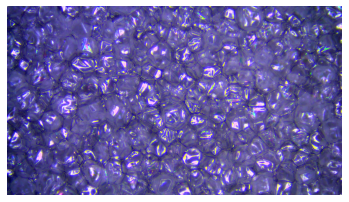

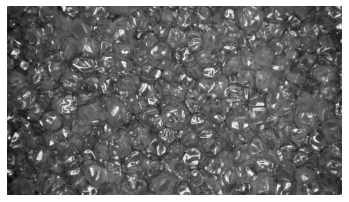

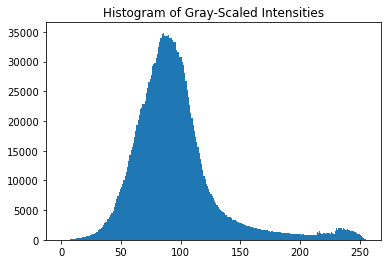

In [33]:
# Access the first image in the first set of the 'ACT' category
first_image = images['ACT'][1][1]

plt.imshow(first_image)
plt.axis('off')  # Hide axes
plt.show()

gray_image = first_image.convert('L')
plt.imshow(gray_image, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

gray_intensities = np.asarray(gray_image).ravel()
bins = range(256) #bins are left inclusive, right exclusive (see plt.hist documentation)
plt.hist(gray_intensities,bins)
plt.title("Histogram of Gray-Scaled Intensities")
plt.show()

# Scalebar Identification

For each object/picture combination, there are four images: An origin, an image with the camera moved to the right $100 \mu m$ with respect to the origin, an image with the camera moved down $100 \mu m$ with respect to the origin, and an image with the camera moved both down and right $100 \mu m$ with respect to the origin. <br>

From this information, we need to extract a scalebar (to the nearest pixel). To do this, let's think about just the origin image and the image with the camera moved to the right. In the image moved to the right, there are now $100 \mu m$ worth of pixel columns added to the right of the image that were not visible in the origin image. Simultaneously, there are now $100 \mu m$ worth of pixel columns visible on the left side of the origin image that are not visible in the image with the camera moved to the right. <br>

We can take advantage of this by ignoring the first $k$ columns in the origin image and the last $k$ columns in the right-shifted image and then subtracting the two images from each other element-wise and computing the squared residual. This residual scales with the number of columns included, so we also need to normalize by dividing by $n_{\textrm{col}} - k$. Then, to recover an estimate of the number of pixels corresponding to our scale bar, we just find the $k$ which minimizes our normalized squared residual. To get another estimate, we can perform an identical operation for the 'down' and 'down-right' images. We can also do the same thing but for rows instead of columns with the ('origin','down') and ('right', 'down-right') images to get four estimates at how many pixels $k$ our shift corresponds to, which we can average to get a final scale-bar.

In [9]:
def shift_resid(k, origin, image, shift_dir):
    k = int(k)
    n_row, n_col = origin.shape
    
    #camera moves right between origin & image
    if shift_dir == 'r':
        o_shift = origin[:, k:] #remove first k columns
        i_shift = image[:,:n_col-k] #remove last k columns
        resid = np.sum(np.power(np.subtract(o_shift, i_shift),2))/(n_col-k) 
        return resid
    
    #camera moves down between origin & image
    if shift_dir == 'd':
        o_shift = origin[k:, :] #remove first k columns
        i_shift = image[:n_row-k,:] #remove last k columns 
        resid = np.sum(np.power(np.subtract(o_shift, i_shift),2))/(n_row-k)
        return resid
    
def minimize(origin, image, shift_dir):
    n_row, n_col = origin.shape
    
    #camera moves right between origin & image
    if shift_dir == 'r':
        resids = [shift_resid(k, origin, image, shift_dir) for k in range(n_col)]
        
    #camera moves down between origin & image
    if shift_dir == 'd':
        resids = [shift_resid(k, origin, image, shift_dir) for k in range(n_row)]
        
    return resids
    
def scalebar (origin, right, down_right, down): 
    k_or = np.argmin(minimize(origin, right, 'r'))
    k_ddr = np.argmin(minimize(down, down_right, 'r'))
    k_od = np.argmin(minimize(origin, down, 'd'))
    k_rdr = np.argmin(minimize(right, down_right, 'd'))
    
    
    avg_k = np.mean([k_or, k_ddr, k_od, k_rdr])
    std_k = np.std([k_or, k_ddr, k_od, k_rdr])
    
    return avg_k, std_k, k_or, k_ddr, k_od, k_rdr
    

**Scalebar Example**

In [5]:
origin_A1 = np.asarray(images['ACT'][1][3].convert('L'))
right_A1 = np.asarray(images['ACT'][1][2].convert('L')) #camera moved to the right 100u from origin
down_right_A1 = np.asarray(images['ACT'][1][1].convert('L')) #camera moved down 100u and right 100u from origin
down_A1 = np.asarray(images['ACT'][1][0].convert('L')) #camera moved down 100u from origin

In [6]:
#camera move right
k_or = minimize(origin_A1, right_A1, 'r')
k_ddr = minimize(down_A1, down_right_A1, 'r')

#camera move down
k_od = minimize(origin_A1, down_A1, 'd')
k_rdr = minimize(right_A1, down_right_A1, 'd')

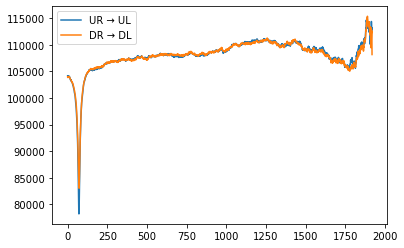

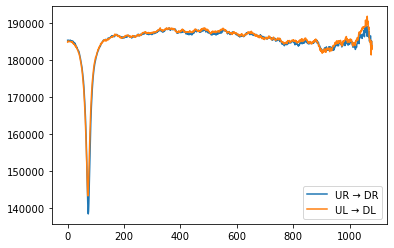

In [7]:
plt.plot(k_or, label = 'UR → UL')
plt.plot(k_ddr, label = 'DR → DL')
plt.legend()
plt.show()

plt.plot(k_od, label = 'UR → DR')
plt.plot(k_rdr, label = 'UL → DL')
plt.legend()
plt.show()

In [20]:
pix_scalebar = scalebar(origin_A1, right_A1, down_right_A1, down_A1)
print(f"The average size of a 100 micron scalebar is {pix_scalebar[0]:.3f} ± {pix_scalebar[1]:.3f} pixels!")

The average size of a 100 micron scalebar is 72.000 ± 0.707 pixels!


# Morphological Filtering

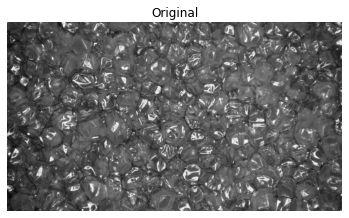

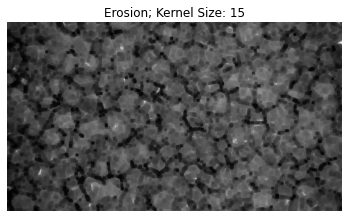

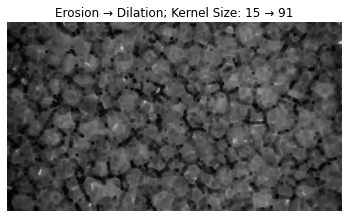

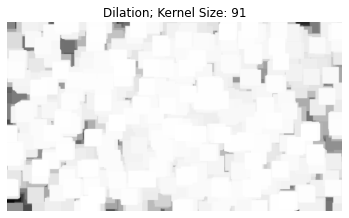

In [123]:
gray_image = np.asarray(gray_image)

erode_size = 15
kernel_e = np.ones((erode_size, erode_size))

dilate_size = 91
kernel_d = np.ones((dilate_size, dilate_size))

#grey image
plt.imshow(gray_image, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.title("Original")
plt.show()

#erosion
erode = cv.erode(gray_image, kernel_e)
plt.imshow(erode, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.title(f"Erosion; Kernel Size: {erode_size}")
plt.show()

#erode, then dilate
erode = cv.erode(gray_image, kernel_e)
dilate = cv.dilate(erode, kernel_d)
plt.imshow(erode, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.title(f"Erosion → Dilation; Kernel Size: {erode_size} → {dilate_size}")
plt.show()

#dilation
dilate = cv.dilate(gray_image, kernel_d)
plt.imshow(dilate, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.title(f"Dilation; Kernel Size: {dilate_size}")
plt.show()



# Edge Detection

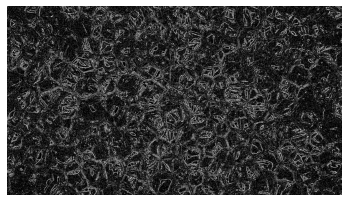

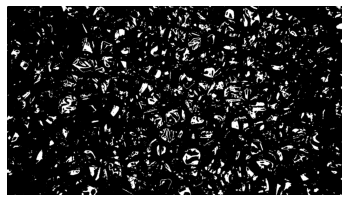

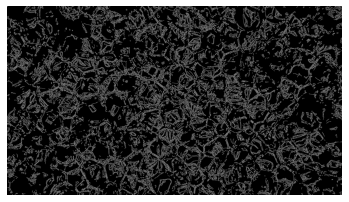

In [84]:
gray_image = np.asarray(gray_image)



#adaptive thresholding
th1 = cv.adaptiveThreshold(gray_image,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,3,-1)

#Otsu's Thresholding
ret2,th2 = cv.threshold(gray_image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

#Canny
th3 = cv.Canny(gray_image,60,100)


plt.imshow(th1, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.show()

plt.imshow(th2, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.show()

plt.imshow(th3, cmap = 'gray')
plt.axis('off')  # Hide axes
plt.show()

# PCA

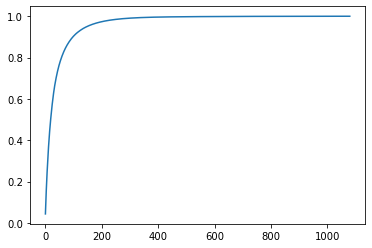

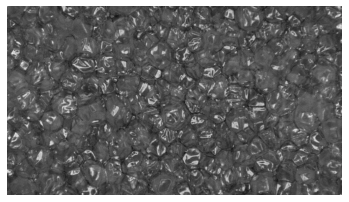

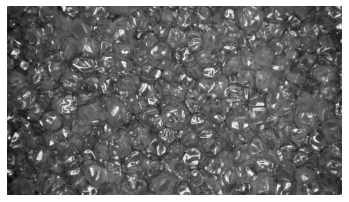

In [31]:
A = np.asarray(gray_image)
A = A - np.mean(A, axis = 0)


U,S,V = np.linalg.svd(A)

varfrac = np.cumsum(S**2)/np.sum(S**2)
plt.plot(varfrac)
plt.show()

k = 175
rank_k = np.linalg.multi_dot([U[:, :k], np.diag(S[:k]), V[:k]])


plt.imshow(rank_k, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()
plt.imshow(gray_image, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()